# TD3 电磁式阻尼器振动控制训练

本notebook用于训练基于全连接网络架构的TD3算法，用于电磁式阻尼器的振动控制，

## 主要特点
- 使用TD3（Twin Delayed Deep Deterministic Policy Gradient）算法
- 针对电磁式阻尼器系统的振动控制优化

### 训练参数

In [1]:
# 参数设置
train_model = True

# 环境参数
ENV_PARAMS = {
    'Ts': 0.001,  # 采样时间
    'T': 1.0,    # 仿真时长
    'state0':[0.0, 0.0, 0.0, 0.0, 1.0, 0.0], # 初始状态
    # 观测状态列表
    # 0: 吸振器位移 (x1)
    # 1: 吸振器速度 (v1)
    # 2: 吸振器加速度 (a1)
    # 3: 平台位移 (x2)
    # 4: 平台速度 (v2)
    # 5: 平台加速度 (a2)
    'observation_indices': [0,2,3,5],  # 观测状态索引
    'x1_limit': 0.01,      # x1 位移限制
    # 'seq_len': 10,              # GRU序列长度
    'use_time_input': False,    # 无时间感知
    'use_time_noise': False,    # 不使用时间噪声
    'time_noise_std': 0.1       # 时间噪声标准差
}

# TD3参数
TD3_PARAMS = {
    'state_dim': len(ENV_PARAMS['observation_indices']),  # 观测维度（平台位移）
    'hidden_dim': 64,          # 隐藏层维度
    'action_bound': 5.0,        # 动作范围
    'actor_lr': 1e-4,           # Actor学习率
    'critic_lr': 1e-3,          # Critic学习率
    'gamma': 0.99,              # 折扣因子
    'tau': 0.005,               # 软更新参数
    'policy_noise': 0.1,        # 策略噪声
    'noise_clip': 0.5,          # 噪声裁剪
    'policy_freq': 2,           # 策略更新频率
    'sigma': 0.05,               # 探索噪声
    'rand_prob': 0,          # 随机动作概率
    'clip_grad': False           # 是否裁剪梯度
}

# 训练参数
TRAIN_PARAMS = {
    'tolerance': 0.0001,          # 容忍度
    'n_episodes': 400,           # 训练轮次
    'capacity': int(1e6),       # 经验回放池容量
    'min_buffer_size': int(5e3),# 最小缓冲区大小
    'print_interval': 5,        # 打印间隔
    'save_interval': 1,         # 保存间隔
    'batch_size': 128,         # 批次大小
    }

### 仿真环境搭建

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from datetime import datetime
import os

# 导入自定义模块
from TD3 import TD3Agent
from nn import ReplayBuffer
from env import ElectromagneticDamperEnv
from train import train_td3
from af import Datasets, STATES_NAME, plot_compare_no_control

# 设置中文字体和GPU
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 设置随机种子
# np.random.seed(42)
# torch.manual_seed(42)
print(f"使用设备: {device}")

使用设备: cuda


In [3]:
# 日志文件
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# 创建保存模型的基础目录
base_dir = ".\\savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认项目文件夹
project_name = input("请输入加载/创建项目的名称 (父目录: .\\savedata) ").strip()
project_path = os.path.join(base_dir, project_name)

# 检查项目文件夹是否存在
is_new_project = not os.path.exists(project_path)
os.makedirs(project_path, exist_ok=True)

# 创建检查点保存目录
save_checkpoint_path = os.path.join(project_path, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)

# 创建绘图保存目录
save_plot_path = os.path.join(project_path, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = os.path.join(project_path, f'training_log_{current_time}.log')
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = os.path.join(project_path, f'training_log_{current_time}.log')

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", project_path)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)
logging.info("环境参数: %s", ENV_PARAMS)
logging.info("算法参数: %s", TD3_PARAMS)
logging.info("训练参数: %s", TRAIN_PARAMS)
print(f"日志文件: {file_path}")

日志文件: .\savedata\cs\training_log_20250817_111518.log


In [4]:
# 系统参数
m = 1.5    # 电磁吸振器质量
M = 20  # 待减振对象质量
k_m = 30_000  # 电磁吸振器刚度
k_M = 300_000  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 0.1  # 电磁吸振器阻尼
c_M = 1.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T
logging.info("系统参数: m=%.2f, M=%.2f, k_m=%.2f, k_M=%.2f, k_f=%.2f, k_E=%.2f, L=%.4f, R_m=%.2f, c_m=%.2f, c_M=%.2f", 
             m, M, k_m, k_M, k_f, k_E, L, R_m, c_m, c_M)

In [5]:
# 定义扰动函数和奖励函数
import inspect

from fx import zero, sin_wave
# z_func = sin_wave(amplitude=0.01, frequency=30, phase=0)
z_func = zero
from fx import tolerance_if_rf
r_func = tolerance_if_rf(tolerance=TRAIN_PARAMS['tolerance'])

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))
if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

In [6]:
# 初始化环境
env = ElectromagneticDamperEnv(
    A=A, B=B, C=C, D=D, E=E,
    Ts=ENV_PARAMS['Ts'],  # 采样时间
    T=ENV_PARAMS['T'],    # 仿真时长
    z_func=z_func,
    r_func=r_func,
    state0=np.array(ENV_PARAMS['state0']),  # 初始状态
    obs_indices=ENV_PARAMS['observation_indices'],  # 观测状态索引
    x1_limit=ENV_PARAMS['x1_limit'],  # x1 位移限制
    use_time_input=ENV_PARAMS['use_time_input'],  # 是否使用时间作为输入
    use_time_noise=ENV_PARAMS['use_time_noise'], # 是否使用时间噪声
    time_noise_std=ENV_PARAMS['time_noise_std'] # 时间噪声标准差
)

logging.info("环境初始化完成，观测维度: %s", [STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']])
print(f"环境初始化完成，观测维度: {[STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']]}")

环境初始化完成，观测维度: ['吸振器位移 (x1)', '吸振器加速度 (a1)', '平台位移 (x2)', '平台加速度 (a2)']


In [ ]:
# 环境测试
test_datasets = env.run_simulation()
test_datasets.plot_episode_history(plot_state=[0, 3, 5], plot_reward=True, save_path=save_plot_path, show=True)

仿真进度: 100%|██████████| 1000/1000 [00:00<00:00, 6408.91it/s]


In [ ]:
# 初始化GRU-TD3代理
agent = TD3Agent(
    state_dim=len(ENV_PARAMS['observation_indices']),  # 观测维度
    action_dim=1,
    hidden_dim=TD3_PARAMS['hidden_dim'],
    action_bound=TD3_PARAMS['action_bound'],
    actor_lr=TD3_PARAMS['actor_lr'],
    critic_lr=TD3_PARAMS['critic_lr'],
    gamma=TD3_PARAMS['gamma'],
    tau=TD3_PARAMS['tau'],
    policy_noise=TD3_PARAMS['policy_noise'],
    noise_clip=TD3_PARAMS['noise_clip'],
    policy_freq=TD3_PARAMS['policy_freq'],
    sigma=TD3_PARAMS['sigma'],
    clip_grad=TD3_PARAMS['clip_grad']
)
logging.info("TD3代理初始化完成")
print("TD3代理初始化完成")

# 写入网络架构到日志
logging.info(f"Actor网络架构:{agent.actor}")
logging.info(f"Critic网络架构:{agent.critic1}")

# 初始化经验回放池
replay_buffer = ReplayBuffer(
    capacity=TRAIN_PARAMS['capacity'],  # 经验回放池容量
    batch_size=TRAIN_PARAMS['batch_size'],
)
logging.info("经验回放池初始化完成")
print("经验回放池初始化完成")

TD3代理初始化完成
经验回放池初始化完成


### 训练

In [ ]:
# 初始化
print(agent.actor.net[-2].state_dict()['bias'])

tensor([0.], device='cuda:0')


In [ ]:
# 加载先前的数据
train_datasets = Datasets()
# 加载先前训练的模型（如果存在）
start_episode = train_datasets.load_datasets(agent, save_checkpoint_path)
print(agent.actor.net[-2].state_dict()['bias'])
logging.info(f"加载了第 {start_episode} 轮的训练数据")
print(f"加载了第 {start_episode} 轮训练数据")

tensor([0.], device='cuda:0')
加载了第 0 轮训练数据


In [ ]:
# 开始训练
if train_model:
    logging.info("开始TD3训练（全连接版本）")
    try:
        # 执行训练
        train_datasets = train_td3(
            env=env,
            agent=agent,
            replay_buffer=replay_buffer,
            n_episodes=TRAIN_PARAMS['n_episodes'], # 训练轮次
            min_buffer_size=TRAIN_PARAMS['min_buffer_size'], # 最小缓冲池大小
            print_interval=TRAIN_PARAMS['print_interval'], # 打印间隔
            save_interval=TRAIN_PARAMS['save_interval'], # 保存间隔
            project_path=project_path,
            save_checkpoint_path=save_checkpoint_path,
            save_plot_path=save_plot_path,
            rand_prob=TD3_PARAMS['rand_prob'],  # 随机动作概率
            train_datasets=train_datasets  # 数据集对象
        )
        
        print("训练完成！")
        logging.info("训练完成！")
        
    except KeyboardInterrupt:
        print("训练被用户中断")
        logging.info("训练被用户中断")
    except Exception as e:
        print(f"训练过程中发生错误: {e}")
        logging.error(f"训练过程中发生错误: {e}")
        raise

训练轮次:   0%|          | 0/400 [00:00<?, ?it/s]

tensor([0.], device='cuda:0')


训练轮次:   0%|          | 1/400 [00:02<16:19,  2.45s/it]

tensor([0.], device='cuda:0')


训练轮次:   0%|          | 2/400 [00:04<16:15,  2.45s/it]

tensor([0.], device='cuda:0')


训练轮次:   1%|          | 3/400 [00:07<16:13,  2.45s/it]

tensor([0.], device='cuda:0')


训练轮次:   1%|          | 4/400 [00:10<17:18,  2.62s/it]

tensor([0.], device='cuda:0')


训练轮次:   1%|▏         | 5/400 [00:13<17:46,  2.70s/it]

  net.0.weight: grad_norm=0.017080
  net.0.bias: grad_norm=0.000324
  net.2.weight: grad_norm=0.020559
  net.2.bias: grad_norm=0.000314
  net.4.weight: grad_norm=0.477623
  net.4.bias: grad_norm=0.009929
🔍 Actor总梯度范数: 0.478474, 参数数量: 6
  net.0.weight: grad_norm=0.023412
  net.0.bias: grad_norm=0.000719
  net.2.weight: grad_norm=0.028712
  net.2.bias: grad_norm=0.000910
  net.4.weight: grad_norm=0.510952
  net.4.bias: grad_norm=0.022460
🔍 Actor总梯度范数: 0.512786, 参数数量: 6
  net.0.weight: grad_norm=0.012310
  net.0.bias: grad_norm=0.000627
  net.2.weight: grad_norm=0.016337
  net.2.bias: grad_norm=0.000850
  net.4.weight: grad_norm=0.258534
  net.4.bias: grad_norm=0.013696
🔍 Actor总梯度范数: 0.259706, 参数数量: 6
  net.0.weight: grad_norm=0.005401
  net.0.bias: grad_norm=0.000315
  net.2.weight: grad_norm=0.006715
  net.2.bias: grad_norm=0.000397
  net.4.weight: grad_norm=0.090171
  net.4.bias: grad_norm=0.004757
🔍 Actor总梯度范数: 0.090708, 参数数量: 6
  net.0.weight: grad_norm=0.003140
  net.0.bias: grad_no

训练轮次:   2%|▏         | 6/400 [00:30<49:59,  7.61s/it]

  net.0.weight: grad_norm=0.028173
  net.0.bias: grad_norm=0.000802
  net.2.weight: grad_norm=0.038353
  net.2.bias: grad_norm=0.001117
  net.4.weight: grad_norm=0.640086
  net.4.bias: grad_norm=0.025436
🔍 Actor总梯度范数: 0.642358, 参数数量: 6
  net.0.weight: grad_norm=0.042752
  net.0.bias: grad_norm=0.001292
  net.2.weight: grad_norm=0.049764
  net.2.bias: grad_norm=0.001698
  net.4.weight: grad_norm=0.708599
  net.4.bias: grad_norm=0.045282
🔍 Actor总梯度范数: 0.713072, 参数数量: 6
  net.0.weight: grad_norm=0.037668
  net.0.bias: grad_norm=0.000712
  net.2.weight: grad_norm=0.042877
  net.2.bias: grad_norm=0.001058
  net.4.weight: grad_norm=0.535145
  net.4.bias: grad_norm=0.022129
🔍 Actor总梯度范数: 0.538636, 参数数量: 6
  net.0.weight: grad_norm=0.037846
  net.0.bias: grad_norm=0.000739
  net.2.weight: grad_norm=0.042448
  net.2.bias: grad_norm=0.000917
  net.4.weight: grad_norm=0.519487
  net.4.bias: grad_norm=0.017488
🔍 Actor总梯度范数: 0.522884, 参数数量: 6
  net.0.weight: grad_norm=0.078934
  net.0.bias: grad_no

训练轮次:   2%|▏         | 7/400 [00:43<1:01:34,  9.40s/it]

  net.0.weight: grad_norm=0.024588
  net.0.bias: grad_norm=0.000707
  net.2.weight: grad_norm=0.024283
  net.2.bias: grad_norm=0.000523
  net.4.weight: grad_norm=0.144202
  net.4.bias: grad_norm=0.000900
🔍 Actor总梯度范数: 0.148290, 参数数量: 6
  net.0.weight: grad_norm=0.091731
  net.0.bias: grad_norm=0.002364
  net.2.weight: grad_norm=0.117111
  net.2.bias: grad_norm=0.003394
  net.4.weight: grad_norm=1.132793
  net.4.bias: grad_norm=0.077526
🔍 Actor总梯度范数: 1.145154, 参数数量: 6
  net.0.weight: grad_norm=0.057902
  net.0.bias: grad_norm=0.001379
  net.2.weight: grad_norm=0.066166
  net.2.bias: grad_norm=0.001316
  net.4.weight: grad_norm=0.534498
  net.4.bias: grad_norm=0.005247
🔍 Actor总梯度范数: 0.541711, 参数数量: 6
  net.0.weight: grad_norm=0.133305
  net.0.bias: grad_norm=0.002297
  net.2.weight: grad_norm=0.174592
  net.2.bias: grad_norm=0.003113
  net.4.weight: grad_norm=1.969218
  net.4.bias: grad_norm=0.060319
🔍 Actor总梯度范数: 1.982354, 参数数量: 6
  net.0.weight: grad_norm=0.101474
  net.0.bias: grad_no

训练轮次:   2%|▏         | 8/400 [00:56<1:09:56, 10.71s/it]

  net.0.weight: grad_norm=0.144280
  net.0.bias: grad_norm=0.007028
  net.2.weight: grad_norm=0.135923
  net.2.bias: grad_norm=0.006767
  net.4.weight: grad_norm=0.947428
  net.4.bias: grad_norm=0.066198
🔍 Actor总梯度范数: 0.970252, 参数数量: 6
  net.0.weight: grad_norm=0.078459
  net.0.bias: grad_norm=0.001299
  net.2.weight: grad_norm=0.077535
  net.2.bias: grad_norm=0.001346
  net.4.weight: grad_norm=0.502724
  net.4.bias: grad_norm=0.018069
🔍 Actor总梯度范数: 0.515004, 参数数量: 6
  net.0.weight: grad_norm=0.105395
  net.0.bias: grad_norm=0.006008
  net.2.weight: grad_norm=0.099578
  net.2.bias: grad_norm=0.005356
  net.4.weight: grad_norm=0.446891
  net.4.bias: grad_norm=0.011764
🔍 Actor总梯度范数: 0.470041, 参数数量: 6
  net.0.weight: grad_norm=0.105166
  net.0.bias: grad_norm=0.004459
  net.2.weight: grad_norm=0.087587
  net.2.bias: grad_norm=0.004246
  net.4.weight: grad_norm=0.857866
  net.4.bias: grad_norm=0.059818
🔍 Actor总梯度范数: 0.870793, 参数数量: 6
  net.0.weight: grad_norm=0.194465
  net.0.bias: grad_no

训练轮次:   2%|▏         | 9/400 [01:10<1:15:50, 11.64s/it]

  net.0.weight: grad_norm=0.099107
  net.0.bias: grad_norm=0.003757
  net.2.weight: grad_norm=0.115458
  net.2.bias: grad_norm=0.003766
  net.4.weight: grad_norm=0.503899
  net.4.bias: grad_norm=0.035599
🔍 Actor总梯度范数: 0.527601, 参数数量: 6
  net.0.weight: grad_norm=0.142300
  net.0.bias: grad_norm=0.002183
  net.2.weight: grad_norm=0.095586
  net.2.bias: grad_norm=0.001843
  net.4.weight: grad_norm=0.503146
  net.4.bias: grad_norm=0.007623
🔍 Actor总梯度范数: 0.531609, 参数数量: 6
  net.0.weight: grad_norm=0.197005
  net.0.bias: grad_norm=0.002445
  net.2.weight: grad_norm=0.196021
  net.2.bias: grad_norm=0.002105
  net.4.weight: grad_norm=0.875330
  net.4.bias: grad_norm=0.003172
🔍 Actor总梯度范数: 0.918400, 参数数量: 6
  net.0.weight: grad_norm=0.179236
  net.0.bias: grad_norm=0.002425
  net.2.weight: grad_norm=0.143728
  net.2.bias: grad_norm=0.002320
  net.4.weight: grad_norm=0.545887
  net.4.bias: grad_norm=0.014285
🔍 Actor总梯度范数: 0.592445, 参数数量: 6
  net.0.weight: grad_norm=0.144084
  net.0.bias: grad_no

训练轮次:   2%|▎         | 10/400 [01:23<1:17:33, 11.93s/it]

  net.0.weight: grad_norm=0.199193
  net.0.bias: grad_norm=0.003447
  net.2.weight: grad_norm=0.144158
  net.2.bias: grad_norm=0.004077
  net.4.weight: grad_norm=0.378503
  net.4.bias: grad_norm=0.030697
🔍 Actor总梯度范数: 0.452432, 参数数量: 6
  net.0.weight: grad_norm=0.231793
  net.0.bias: grad_norm=0.009218
  net.2.weight: grad_norm=0.197429
  net.2.bias: grad_norm=0.010658
  net.4.weight: grad_norm=0.457988
  net.4.bias: grad_norm=0.072519
🔍 Actor总梯度范数: 0.554902, 参数数量: 6
  net.0.weight: grad_norm=0.148546
  net.0.bias: grad_norm=0.002614
  net.2.weight: grad_norm=0.165753
  net.2.bias: grad_norm=0.002425
  net.4.weight: grad_norm=0.493465
  net.4.bias: grad_norm=0.006156
🔍 Actor总梯度范数: 0.541386, 参数数量: 6
  net.0.weight: grad_norm=0.311008
  net.0.bias: grad_norm=0.005922
  net.2.weight: grad_norm=0.243786
  net.2.bias: grad_norm=0.004133
  net.4.weight: grad_norm=0.570557
  net.4.bias: grad_norm=0.016500
🔍 Actor总梯度范数: 0.694274, 参数数量: 6
  net.0.weight: grad_norm=0.117183
  net.0.bias: grad_no

训练轮次:   3%|▎         | 11/400 [01:34<1:16:09, 11.75s/it]

  net.0.weight: grad_norm=0.230799
  net.0.bias: grad_norm=0.006449
  net.2.weight: grad_norm=0.229812
  net.2.bias: grad_norm=0.007830
  net.4.weight: grad_norm=0.982667
  net.4.bias: grad_norm=0.058456
🔍 Actor总梯度范数: 1.036936, 参数数量: 6
  net.0.weight: grad_norm=0.516341
  net.0.bias: grad_norm=0.007642
  net.2.weight: grad_norm=0.452194
  net.2.bias: grad_norm=0.008828
  net.4.weight: grad_norm=0.907394
  net.4.bias: grad_norm=0.055029
🔍 Actor总梯度范数: 1.139129, 参数数量: 6
  net.0.weight: grad_norm=0.209703
  net.0.bias: grad_norm=0.004437
  net.2.weight: grad_norm=0.144451
  net.2.bias: grad_norm=0.003669
  net.4.weight: grad_norm=0.508548
  net.4.bias: grad_norm=0.016942
🔍 Actor总梯度范数: 0.569019, 参数数量: 6
  net.0.weight: grad_norm=0.300529
  net.0.bias: grad_norm=0.004940
  net.2.weight: grad_norm=0.220695
  net.2.bias: grad_norm=0.005409
  net.4.weight: grad_norm=0.715228
  net.4.bias: grad_norm=0.042314
🔍 Actor总梯度范数: 0.807725, 参数数量: 6
  net.0.weight: grad_norm=0.281078
  net.0.bias: grad_no

训练轮次:   3%|▎         | 12/400 [01:45<1:15:18, 11.65s/it]

  net.0.weight: grad_norm=0.119298
  net.0.bias: grad_norm=0.002586
  net.2.weight: grad_norm=0.069412
  net.2.bias: grad_norm=0.002348
  net.4.weight: grad_norm=0.260333
  net.4.bias: grad_norm=0.017369
🔍 Actor总梯度范数: 0.295190, 参数数量: 6
  net.0.weight: grad_norm=0.308566
  net.0.bias: grad_norm=0.007918
  net.2.weight: grad_norm=0.332626
  net.2.bias: grad_norm=0.004801
  net.4.weight: grad_norm=0.791454
  net.4.bias: grad_norm=0.025567
🔍 Actor总梯度范数: 0.912684, 参数数量: 6
  net.0.weight: grad_norm=0.544674
  net.0.bias: grad_norm=0.004205
  net.2.weight: grad_norm=0.748256
  net.2.bias: grad_norm=0.003022
  net.4.weight: grad_norm=1.901198
  net.4.bias: grad_norm=0.011788
🔍 Actor总梯度范数: 2.114539, 参数数量: 6
  net.0.weight: grad_norm=0.502846
  net.0.bias: grad_norm=0.007091
  net.2.weight: grad_norm=0.489950
  net.2.bias: grad_norm=0.007314
  net.4.weight: grad_norm=1.696808
  net.4.bias: grad_norm=0.061662
🔍 Actor总梯度范数: 1.837380, 参数数量: 6
  net.0.weight: grad_norm=0.416427
  net.0.bias: grad_no

训练轮次:   3%|▎         | 13/400 [01:57<1:14:31, 11.55s/it]

  net.0.weight: grad_norm=0.249971
  net.0.bias: grad_norm=0.003867
  net.2.weight: grad_norm=0.199351
  net.2.bias: grad_norm=0.002972
  net.4.weight: grad_norm=0.831527
  net.4.bias: grad_norm=0.021746
🔍 Actor总梯度范数: 0.891157, 参数数量: 6
  net.0.weight: grad_norm=0.516644
  net.0.bias: grad_norm=0.005141
  net.2.weight: grad_norm=0.476190
  net.2.bias: grad_norm=0.004761
  net.4.weight: grad_norm=1.438015
  net.4.bias: grad_norm=0.025485
🔍 Actor总梯度范数: 1.600707, 参数数量: 6
  net.0.weight: grad_norm=0.283923
  net.0.bias: grad_norm=0.006322
  net.2.weight: grad_norm=0.326139
  net.2.bias: grad_norm=0.007352
  net.4.weight: grad_norm=1.096267
  net.4.bias: grad_norm=0.056610
🔍 Actor总梯度范数: 1.179864, 参数数量: 6
  net.0.weight: grad_norm=0.391937
  net.0.bias: grad_norm=0.003282
  net.2.weight: grad_norm=0.378632
  net.2.bias: grad_norm=0.003272
  net.4.weight: grad_norm=0.689928
  net.4.bias: grad_norm=0.020768
🔍 Actor总梯度范数: 0.879449, 参数数量: 6
  net.0.weight: grad_norm=0.453891
  net.0.bias: grad_no

训练轮次:   4%|▎         | 14/400 [02:08<1:14:03, 11.51s/it]

  net.0.weight: grad_norm=0.768981
  net.0.bias: grad_norm=0.016750
  net.2.weight: grad_norm=0.831749
  net.2.bias: grad_norm=0.019097
  net.4.weight: grad_norm=2.569560
  net.4.bias: grad_norm=0.027873
🔍 Actor总梯度范数: 2.808416, 参数数量: 6
  net.0.weight: grad_norm=1.000038
  net.0.bias: grad_norm=0.006511
  net.2.weight: grad_norm=1.406894
  net.2.bias: grad_norm=0.004500
  net.4.weight: grad_norm=4.802162
  net.4.bias: grad_norm=0.026615
🔍 Actor总梯度范数: 5.103034, 参数数量: 6
  net.0.weight: grad_norm=1.949316
  net.0.bias: grad_norm=0.008216
  net.2.weight: grad_norm=2.818712
  net.2.bias: grad_norm=0.014589
  net.4.weight: grad_norm=9.438756
  net.4.bias: grad_norm=0.075364
🔍 Actor总梯度范数: 10.041964, 参数数量: 6
  net.0.weight: grad_norm=2.255411
  net.0.bias: grad_norm=0.029798
  net.2.weight: grad_norm=2.838197
  net.2.bias: grad_norm=0.048154
  net.4.weight: grad_norm=7.719405
  net.4.bias: grad_norm=0.210528
🔍 Actor总梯度范数: 8.531060, 参数数量: 6
  net.0.weight: grad_norm=0.552000
  net.0.bias: grad_n

训练轮次:   4%|▍         | 15/400 [02:21<1:15:44, 11.80s/it]

  net.0.weight: grad_norm=1.155212
  net.0.bias: grad_norm=0.014982
  net.2.weight: grad_norm=1.519304
  net.2.bias: grad_norm=0.022070
  net.4.weight: grad_norm=4.898453
  net.4.bias: grad_norm=0.098662
🔍 Actor总梯度范数: 5.258145, 参数数量: 6
  net.0.weight: grad_norm=0.820273
  net.0.bias: grad_norm=0.006576
  net.2.weight: grad_norm=1.154768
  net.2.bias: grad_norm=0.011242
  net.4.weight: grad_norm=3.664231
  net.4.bias: grad_norm=0.059659
🔍 Actor总梯度范数: 3.928950, 参数数量: 6
  net.0.weight: grad_norm=0.469847
  net.0.bias: grad_norm=0.009977
  net.2.weight: grad_norm=0.545900
  net.2.bias: grad_norm=0.013981
  net.4.weight: grad_norm=1.385322
  net.4.bias: grad_norm=0.078975
🔍 Actor总梯度范数: 1.563462, 参数数量: 6
  net.0.weight: grad_norm=0.550212
  net.0.bias: grad_norm=0.011802
  net.2.weight: grad_norm=0.463388
  net.2.bias: grad_norm=0.008261
  net.4.weight: grad_norm=0.732371
  net.4.bias: grad_norm=0.007034
🔍 Actor总梯度范数: 1.026687, 参数数量: 6
  net.0.weight: grad_norm=0.946065
  net.0.bias: grad_no

训练轮次:   4%|▍         | 16/400 [02:35<1:20:21, 12.55s/it]

  net.0.weight: grad_norm=2.132293
  net.0.bias: grad_norm=0.019968
  net.2.weight: grad_norm=2.867565
  net.2.bias: grad_norm=0.034251
  net.4.weight: grad_norm=8.286801
  net.4.bias: grad_norm=0.157672
🔍 Actor总梯度范数: 9.025913, 参数数量: 6
  net.0.weight: grad_norm=1.349569
  net.0.bias: grad_norm=0.010733
  net.2.weight: grad_norm=1.616696
  net.2.bias: grad_norm=0.016935
  net.4.weight: grad_norm=4.380445
  net.4.bias: grad_norm=0.084540
🔍 Actor总梯度范数: 4.861162, 参数数量: 6
  net.0.weight: grad_norm=0.432578
  net.0.bias: grad_norm=0.008891
  net.2.weight: grad_norm=0.466594
  net.2.bias: grad_norm=0.007439
  net.4.weight: grad_norm=0.873023
  net.4.bias: grad_norm=0.022765
🔍 Actor总梯度范数: 1.080581, 参数数量: 6
  net.0.weight: grad_norm=0.574116
  net.0.bias: grad_norm=0.009467
  net.2.weight: grad_norm=0.563549
  net.2.bias: grad_norm=0.013914
  net.4.weight: grad_norm=1.209379
  net.4.bias: grad_norm=0.061325
🔍 Actor总梯度范数: 1.453904, 参数数量: 6
  net.0.weight: grad_norm=0.981647
  net.0.bias: grad_no

训练轮次:   4%|▍         | 17/400 [02:48<1:21:17, 12.73s/it]

  net.0.weight: grad_norm=0.918478
  net.0.bias: grad_norm=0.009258
  net.2.weight: grad_norm=0.952828
  net.2.bias: grad_norm=0.013556
  net.4.weight: grad_norm=2.544995
  net.4.bias: grad_norm=0.079655
🔍 Actor总梯度范数: 2.869685, 参数数量: 6
  net.0.weight: grad_norm=1.191591
  net.0.bias: grad_norm=0.010089
  net.2.weight: grad_norm=1.212513
  net.2.bias: grad_norm=0.013559
  net.4.weight: grad_norm=4.927646
  net.4.bias: grad_norm=0.074911
🔍 Actor总梯度范数: 5.213220, 参数数量: 6
  net.0.weight: grad_norm=1.505378
  net.0.bias: grad_norm=0.008432
  net.2.weight: grad_norm=1.606325
  net.2.bias: grad_norm=0.010689
  net.4.weight: grad_norm=4.134614
  net.4.bias: grad_norm=0.029720
🔍 Actor总梯度范数: 4.684287, 参数数量: 6
  net.0.weight: grad_norm=0.833051
  net.0.bias: grad_norm=0.008355
  net.2.weight: grad_norm=0.942392
  net.2.bias: grad_norm=0.010502
  net.4.weight: grad_norm=3.070529
  net.4.bias: grad_norm=0.059564
🔍 Actor总梯度范数: 3.318727, 参数数量: 6
  net.0.weight: grad_norm=0.983622
  net.0.bias: grad_no

训练轮次:   4%|▍         | 18/400 [03:01<1:21:26, 12.79s/it]

  net.0.weight: grad_norm=1.518217
  net.0.bias: grad_norm=0.015390
  net.2.weight: grad_norm=1.479333
  net.2.bias: grad_norm=0.013226
  net.4.weight: grad_norm=2.347722
  net.4.bias: grad_norm=0.021868
🔍 Actor总梯度范数: 3.163241, 参数数量: 6
  net.0.weight: grad_norm=0.628262
  net.0.bias: grad_norm=0.008511
  net.2.weight: grad_norm=0.711828
  net.2.bias: grad_norm=0.010844
  net.4.weight: grad_norm=1.701613
  net.4.bias: grad_norm=0.039035
🔍 Actor总梯度范数: 1.949003, 参数数量: 6
  net.0.weight: grad_norm=1.213253
  net.0.bias: grad_norm=0.017074
  net.2.weight: grad_norm=1.471094
  net.2.bias: grad_norm=0.020618
  net.4.weight: grad_norm=3.636459
  net.4.bias: grad_norm=0.135470
🔍 Actor总梯度范数: 4.108406, 参数数量: 6
  net.0.weight: grad_norm=1.236622
  net.0.bias: grad_norm=0.018937
  net.2.weight: grad_norm=1.623710
  net.2.bias: grad_norm=0.027237
  net.4.weight: grad_norm=4.419249
  net.4.bias: grad_norm=0.161166
🔍 Actor总梯度范数: 4.870575, 参数数量: 6
  net.0.weight: grad_norm=0.529654
  net.0.bias: grad_no

训练轮次:   5%|▍         | 19/400 [03:14<1:21:10, 12.78s/it]

  net.0.weight: grad_norm=0.989949
  net.0.bias: grad_norm=0.014926
  net.2.weight: grad_norm=0.985802
  net.2.bias: grad_norm=0.011346
  net.4.weight: grad_norm=3.063490
  net.4.bias: grad_norm=0.026848
🔍 Actor总梯度范数: 3.367172, 参数数量: 6
  net.0.weight: grad_norm=1.487094
  net.0.bias: grad_norm=0.012278
  net.2.weight: grad_norm=1.275225
  net.2.bias: grad_norm=0.012047
  net.4.weight: grad_norm=3.266420
  net.4.bias: grad_norm=0.044394
🔍 Actor总梯度范数: 3.809123, 参数数量: 6
  net.0.weight: grad_norm=0.718204
  net.0.bias: grad_norm=0.011481
  net.2.weight: grad_norm=0.710445
  net.2.bias: grad_norm=0.015167
  net.4.weight: grad_norm=1.914841
  net.4.bias: grad_norm=0.060380
🔍 Actor总梯度范数: 2.165912, 参数数量: 6
  net.0.weight: grad_norm=0.539194
  net.0.bias: grad_norm=0.004377
  net.2.weight: grad_norm=0.456320
  net.2.bias: grad_norm=0.002963
  net.4.weight: grad_norm=1.159692
  net.4.bias: grad_norm=0.005812
🔍 Actor总梯度范数: 1.357905, 参数数量: 6
  net.0.weight: grad_norm=1.004765
  net.0.bias: grad_no

训练轮次:   5%|▌         | 20/400 [03:26<1:20:44, 12.75s/it]

  net.0.weight: grad_norm=0.877363
  net.0.bias: grad_norm=0.010647
  net.2.weight: grad_norm=0.486423
  net.2.bias: grad_norm=0.010573
  net.4.weight: grad_norm=1.459675
  net.4.bias: grad_norm=0.054954
🔍 Actor总梯度范数: 1.772080, 参数数量: 6
  net.0.weight: grad_norm=1.085248
  net.0.bias: grad_norm=0.005363
  net.2.weight: grad_norm=1.452258
  net.2.bias: grad_norm=0.007601
  net.4.weight: grad_norm=4.145769
  net.4.bias: grad_norm=0.041309
🔍 Actor总梯度范数: 4.525043, 参数数量: 6
  net.0.weight: grad_norm=2.138716
  net.0.bias: grad_norm=0.019324
  net.2.weight: grad_norm=2.805381
  net.2.bias: grad_norm=0.026335
  net.4.weight: grad_norm=8.154822
  net.4.bias: grad_norm=0.108742
🔍 Actor总梯度范数: 8.885848, 参数数量: 6
  net.0.weight: grad_norm=2.062301
  net.0.bias: grad_norm=0.013524
  net.2.weight: grad_norm=2.238509
  net.2.bias: grad_norm=0.009874
  net.4.weight: grad_norm=5.623669
  net.4.bias: grad_norm=0.038190
🔍 Actor总梯度范数: 6.394638, 参数数量: 6
  net.0.weight: grad_norm=0.879708
  net.0.bias: grad_no

训练轮次:   5%|▌         | 21/400 [03:39<1:21:06, 12.84s/it]

  net.0.weight: grad_norm=0.829010
  net.0.bias: grad_norm=0.013961
  net.2.weight: grad_norm=0.744583
  net.2.bias: grad_norm=0.009136
  net.4.weight: grad_norm=1.953181
  net.4.bias: grad_norm=0.007983
🔍 Actor总梯度范数: 2.248759, 参数数量: 6
  net.0.weight: grad_norm=0.793383
  net.0.bias: grad_norm=0.017688
  net.2.weight: grad_norm=0.736099
  net.2.bias: grad_norm=0.014817
  net.4.weight: grad_norm=2.029791
  net.4.bias: grad_norm=0.075000
🔍 Actor总梯度范数: 2.301632, 参数数量: 6
  net.0.weight: grad_norm=0.478542
  net.0.bias: grad_norm=0.020833
  net.2.weight: grad_norm=0.458447
  net.2.bias: grad_norm=0.014383
  net.4.weight: grad_norm=1.041625
  net.4.bias: grad_norm=0.056899
🔍 Actor总梯度范数: 1.236138, 参数数量: 6
  net.0.weight: grad_norm=0.794005
  net.0.bias: grad_norm=0.009457
  net.2.weight: grad_norm=1.043267
  net.2.bias: grad_norm=0.012503
  net.4.weight: grad_norm=3.070945
  net.4.bias: grad_norm=0.055812
🔍 Actor总梯度范数: 3.339598, 参数数量: 6
  net.0.weight: grad_norm=0.667445
  net.0.bias: grad_no

训练轮次:   6%|▌         | 22/400 [03:53<1:21:39, 12.96s/it]

  net.0.weight: grad_norm=1.039345
  net.0.bias: grad_norm=0.008001
  net.2.weight: grad_norm=1.162562
  net.2.bias: grad_norm=0.007977
  net.4.weight: grad_norm=2.969123
  net.4.bias: grad_norm=0.003853
🔍 Actor总梯度范数: 3.353748, 参数数量: 6
  net.0.weight: grad_norm=1.660148
  net.0.bias: grad_norm=0.023575
  net.2.weight: grad_norm=1.508336
  net.2.bias: grad_norm=0.018837
  net.4.weight: grad_norm=4.887496
  net.4.bias: grad_norm=0.007548
🔍 Actor总梯度范数: 5.377709, 参数数量: 6
  net.0.weight: grad_norm=0.390335
  net.0.bias: grad_norm=0.007478
  net.2.weight: grad_norm=0.287848
  net.2.bias: grad_norm=0.008844
  net.4.weight: grad_norm=0.551712
  net.4.bias: grad_norm=0.031463
🔍 Actor总梯度范数: 0.735342, 参数数量: 6
  net.0.weight: grad_norm=0.337978
  net.0.bias: grad_norm=0.005252
  net.2.weight: grad_norm=0.454807
  net.2.bias: grad_norm=0.005707
  net.4.weight: grad_norm=0.833193
  net.4.bias: grad_norm=0.001853
🔍 Actor总梯度范数: 1.007647, 参数数量: 6
  net.0.weight: grad_norm=0.854216
  net.0.bias: grad_no

训练轮次:   6%|▌         | 23/400 [04:05<1:19:56, 12.72s/it]

  net.0.weight: grad_norm=0.564123
  net.0.bias: grad_norm=0.006621
  net.2.weight: grad_norm=0.607767
  net.2.bias: grad_norm=0.006701
  net.4.weight: grad_norm=2.074382
  net.4.bias: grad_norm=0.001301
🔍 Actor总梯度范数: 2.234003, 参数数量: 6
  net.0.weight: grad_norm=0.512510
  net.0.bias: grad_norm=0.015695
  net.2.weight: grad_norm=0.451270
  net.2.bias: grad_norm=0.013037
  net.4.weight: grad_norm=1.226004
  net.4.bias: grad_norm=0.017145
🔍 Actor总梯度范数: 1.403605, 参数数量: 6
  net.0.weight: grad_norm=0.686087
  net.0.bias: grad_norm=0.011713
  net.2.weight: grad_norm=0.919718
  net.2.bias: grad_norm=0.012170
  net.4.weight: grad_norm=3.187888
  net.4.bias: grad_norm=0.066189
🔍 Actor总梯度范数: 3.388789, 参数数量: 6
  net.0.weight: grad_norm=0.210279
  net.0.bias: grad_norm=0.005826
  net.2.weight: grad_norm=0.119722
  net.2.bias: grad_norm=0.003195
  net.4.weight: grad_norm=0.342425
  net.4.bias: grad_norm=0.006007
🔍 Actor总梯度范数: 0.419388, 参数数量: 6
  net.0.weight: grad_norm=0.736150
  net.0.bias: grad_no

训练轮次:   6%|▌         | 24/400 [04:17<1:19:10, 12.63s/it]

  net.0.weight: grad_norm=0.530499
  net.0.bias: grad_norm=0.008398
  net.2.weight: grad_norm=0.742175
  net.2.bias: grad_norm=0.009898
  net.4.weight: grad_norm=2.531387
  net.4.bias: grad_norm=0.043232
🔍 Actor总梯度范数: 2.691136, 参数数量: 6
  net.0.weight: grad_norm=0.456345
  net.0.bias: grad_norm=0.009842
  net.2.weight: grad_norm=0.482117
  net.2.bias: grad_norm=0.009003
  net.4.weight: grad_norm=1.303202
  net.4.bias: grad_norm=0.036863
🔍 Actor总梯度范数: 1.463065, 参数数量: 6
  net.0.weight: grad_norm=0.617161
  net.0.bias: grad_norm=0.024433
  net.2.weight: grad_norm=0.459263
  net.2.bias: grad_norm=0.016589
  net.4.weight: grad_norm=1.459472
  net.4.bias: grad_norm=0.008543
🔍 Actor总梯度范数: 1.650096, 参数数量: 6
  net.0.weight: grad_norm=1.439537
  net.0.bias: grad_norm=0.015509
  net.2.weight: grad_norm=1.654209
  net.2.bias: grad_norm=0.023972
  net.4.weight: grad_norm=4.275360
  net.4.bias: grad_norm=0.109057
🔍 Actor总梯度范数: 4.806255, 参数数量: 6
  net.0.weight: grad_norm=1.697263
  net.0.bias: grad_no

训练轮次:   6%|▋         | 25/400 [04:30<1:19:32, 12.73s/it]

  net.0.weight: grad_norm=0.524514
  net.0.bias: grad_norm=0.006164
  net.2.weight: grad_norm=0.375209
  net.2.bias: grad_norm=0.004803
  net.4.weight: grad_norm=0.779504
  net.4.bias: grad_norm=0.023123
🔍 Actor总梯度范数: 1.011988, 参数数量: 6
  net.0.weight: grad_norm=1.096568
  net.0.bias: grad_norm=0.012537
  net.2.weight: grad_norm=1.154607
  net.2.bias: grad_norm=0.013933
  net.4.weight: grad_norm=2.270815
  net.4.bias: grad_norm=0.068907
🔍 Actor总梯度范数: 2.774397, 参数数量: 6
  net.0.weight: grad_norm=1.399309
  net.0.bias: grad_norm=0.014696
  net.2.weight: grad_norm=1.399882
  net.2.bias: grad_norm=0.018284
  net.4.weight: grad_norm=3.315425
  net.4.bias: grad_norm=0.080062
🔍 Actor总梯度范数: 3.862219, 参数数量: 6
  net.0.weight: grad_norm=0.668890
  net.0.bias: grad_norm=0.012774
  net.2.weight: grad_norm=0.580734
  net.2.bias: grad_norm=0.014471
  net.4.weight: grad_norm=1.164835
  net.4.bias: grad_norm=0.054376
🔍 Actor总梯度范数: 1.464526, 参数数量: 6
  net.0.weight: grad_norm=0.634602
  net.0.bias: grad_no

训练轮次:   6%|▋         | 25/400 [04:37<1:09:28, 11.12s/it]

  net.0.weight: grad_norm=0.989947
  net.0.bias: grad_norm=0.007807
  net.2.weight: grad_norm=1.105286
  net.2.bias: grad_norm=0.008446
  net.4.weight: grad_norm=2.773097
  net.4.bias: grad_norm=0.039111
🔍 Actor总梯度范数: 3.145374, 参数数量: 6
训练被用户中断


### 训练结果可视化

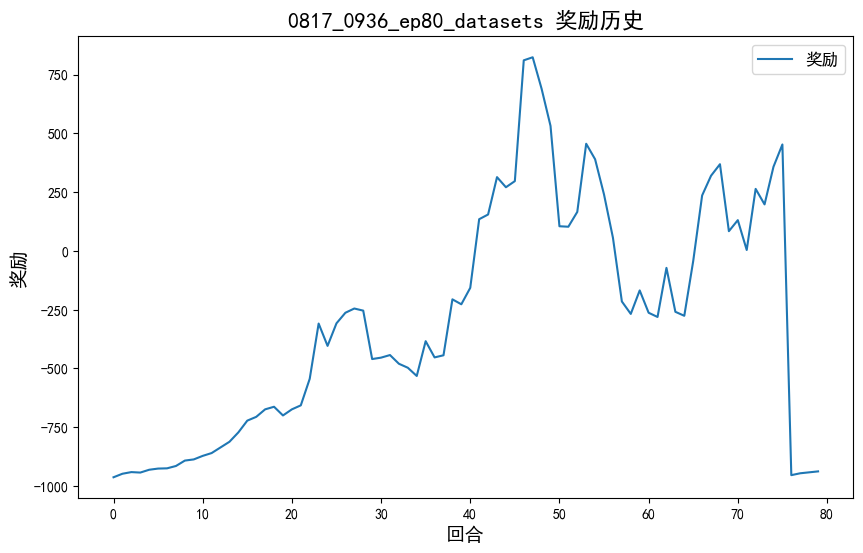

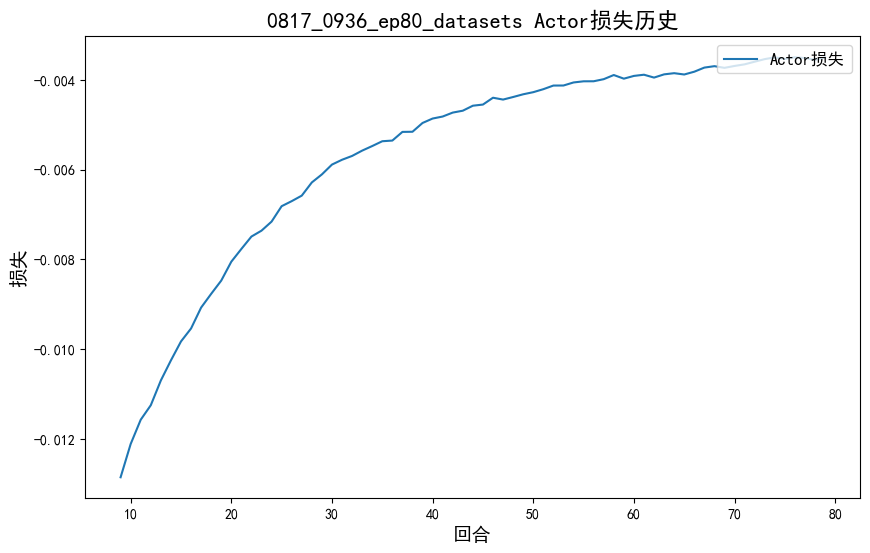

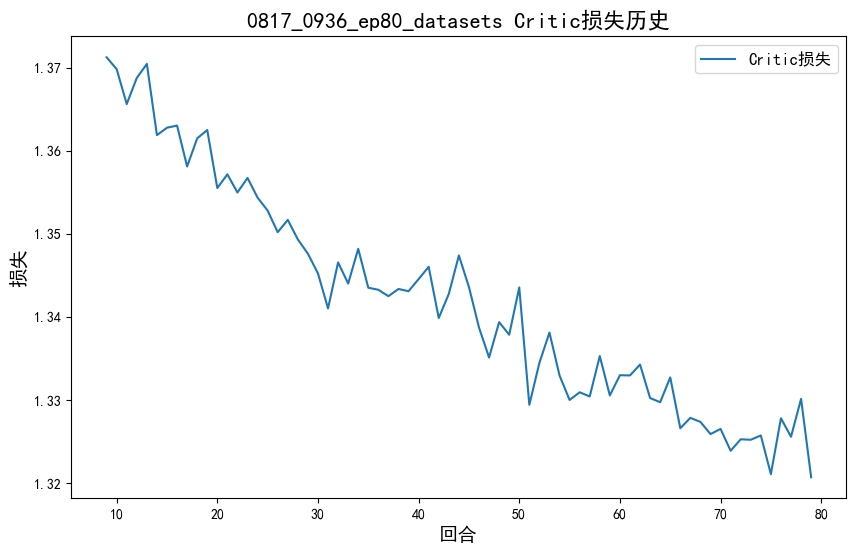

In [ ]:
# 训练历程数据
train_datasets.plot_episode_datas(save_path=project_path, show=True)  # 绘制训练的奖励历程数据图
train_datasets.plot_episode_datas(plot_rewards=False, plot_actor_losses=True, plot_critic_losses=True, show=True)  # 绘制训练历程数据图

仿真进度: 100%|██████████| 1000/1000 [00:01<00:00, 923.14it/s]


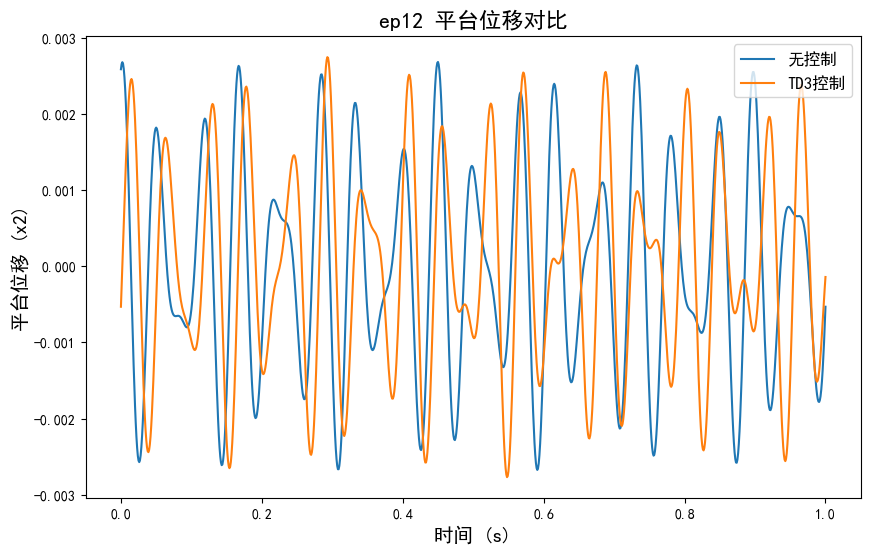

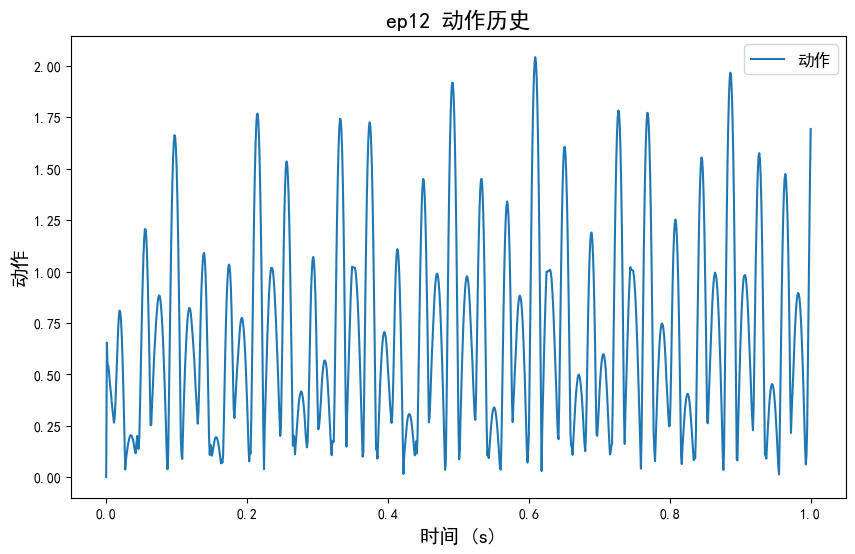

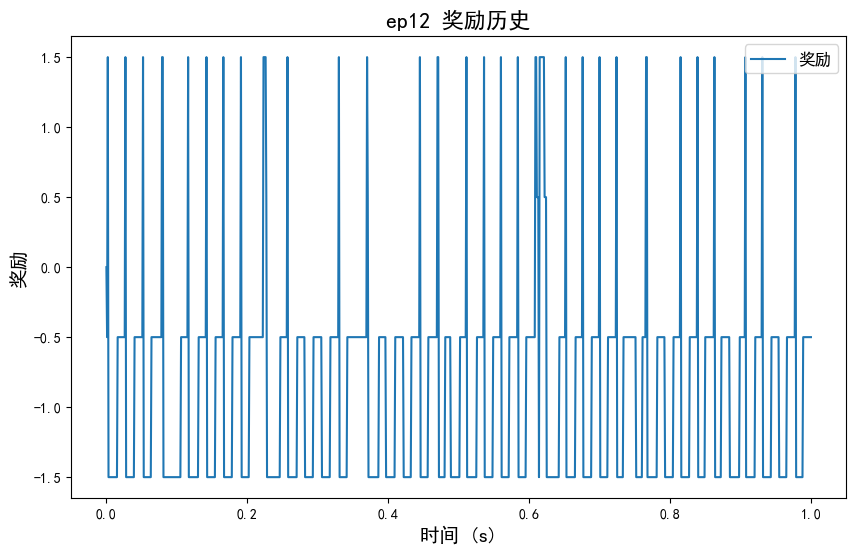

In [ ]:
# 训练对比
nc_datasets = env.run_simulation()
c_datasets = env.run_simulation(controller=agent)
c_datasets.checkpoint_name = f"ep{train_datasets.current_episode}"
plot_compare_no_control(nc_datasets, c_datasets, save_path=save_plot_path, use_time_noise=env.use_time_noise, show=True)